<a href="https://colab.research.google.com/github/SOwens-Create/BabyPython/blob/master/SOwens_High_Code_COVID_19_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: COVID-19 Image Classification

## Problem Statement

### Context

Covid-19 is a fast-growing disease that affects human health severly. Patients diagonised with this condition suffers from lung infection. The medical community has recently released vaccines which have a slower effect in increasing the immunity. This virus has impacted various countries' human health and financial standing.

Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.

### Objective

The aim of this project is to Build a Convolutional Neural Network to differentiate an X-ray image of a person affected with covid from that of a healthy person or a person who has viral pneumonia(fever).

### Data Dictionary

- This dataset contains training set images of 3 classes which are converted into numpy arrays.

- The dataset comprises 3 classes:
  - COVID-19: The patient who is effected due to covid.
  - Viral Pneumonia: This is a viral fever which has similar characteristics like fever and cought that of Covid but is not covid.
  
  - Normal- A healthy Person with no symptoms of covid or fever.
- The data file names are:
  - CovidImages.npy
  - CovidLabels.csv

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Mounting google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/CV_Alternate_Project/CovidImages.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/CV_Alternate_Project/CovidLabels.csv')

## Data Overview

### Understand the shape of the dataset

In [ ]:
#Verify that the images shape and the labels shape match
print(images.shape)
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


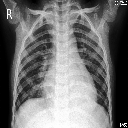

In [ ]:
#Rough idea of what the images look like
cv2_imshow(images[5])

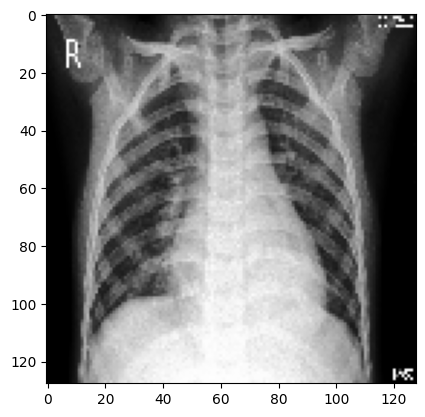

In [ ]:
#Enlarging the image to see pixel values
#Since all of the images are xray images, it is unlikely that we will need to
#convert to black and white, but we will do this in a later step anyway.
plt.imshow(images[5])

## Data Pre-Processing

### Converting the BGR images to RGB images

In [ ]:
# Again, these images appear to be BW or grayscale already, but since we can't see
# all of the images, we should still run the conversion.
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category X-ray images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
# The plot images function brings the labels and images together
# for a preview.

def plot_images(images,labels):
  num_classes=3
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10, 8))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

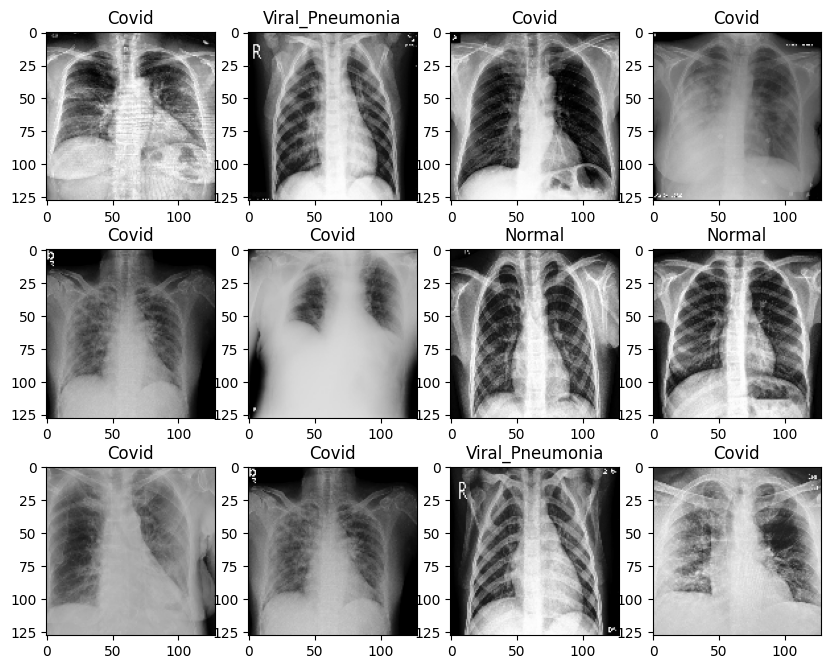

In [ ]:
plot_images(images,labels)

In [ ]:
type(labels)

pandas.core.frame.DataFrame

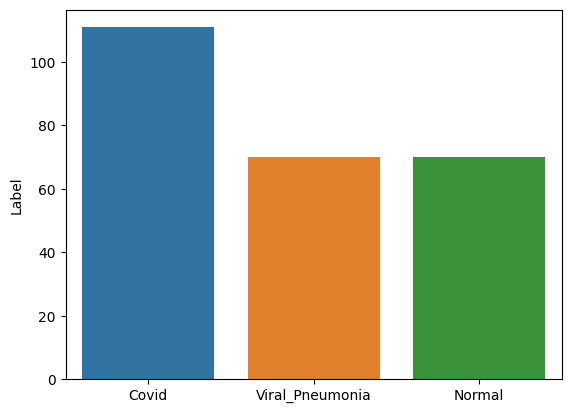

In [ ]:
#In this dataset most of the images are Covid.
#There are equal amounts of images of Viral Pneumonia and Normal
sns.barplot(x=labels['Label'].value_counts().index, y=labels['Label'].value_counts())
plt.show()

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
# We resize the images to 64x64
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

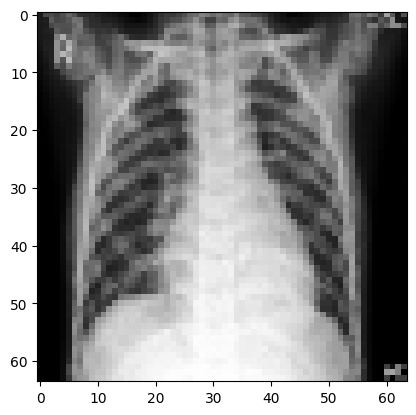

In [ ]:
plt.imshow(images_decreased[5])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
#Splitting the data into training and testing data.
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
#Verifying the shapes and that the data will match before moving to the next step.
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(202, 64, 64, 3) (202, 1)
(23, 64, 64, 3) (23, 1)
(26, 64, 64, 3) (26, 1)


### Encode the target labels

In [ ]:
#Using the label binarizer from class
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(3, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [ ]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
7/7 - 1s - loss: 1.0703 - accuracy: 0.4505 - val_loss: 0.9881 - val_accuracy: 0.6522 - 1s/epoch - 198ms/step
Epoch 2/30
7/7 - 0s - loss: 0.9345 - accuracy: 0.5792 - val_loss: 0.7505 - val_accuracy: 0.7391 - 83ms/epoch - 12ms/step
Epoch 3/30
7/7 - 0s - loss: 0.6916 - accuracy: 0.6634 - val_loss: 0.5014 - val_accuracy: 0.7826 - 76ms/epoch - 11ms/step
Epoch 4/30
7/7 - 0s - loss: 0.5241 - accuracy: 0.8020 - val_loss: 0.3868 - val_accuracy: 0.8696 - 75ms/epoch - 11ms/step
Epoch 5/30
7/7 - 0s - loss: 0.4903 - accuracy: 0.8416 - val_loss: 0.3251 - val_accuracy: 0.9565 - 73ms/epoch - 10ms/step
Epoch 6/30
7/7 - 0s - loss: 0.4199 - accuracy: 0.8465 - val_loss: 0.3835 - val_accuracy: 0.8261 - 80ms/epoch - 11ms/step
Epoch 7/30
7/7 - 0s - loss: 0.4663 - accuracy: 0.8168 - val_loss: 0.2741 - val_accuracy: 0.9565 - 76ms/epoch - 11ms/step
Epoch 8/30
7/7 - 0s - loss: 0.3196 - accuracy: 0.9109 - val_loss: 0.2655 - val_accuracy: 0.9565 - 73ms/epoch - 10ms/step
Epoch 9/30
7/7 - 0s - loss: 0.342

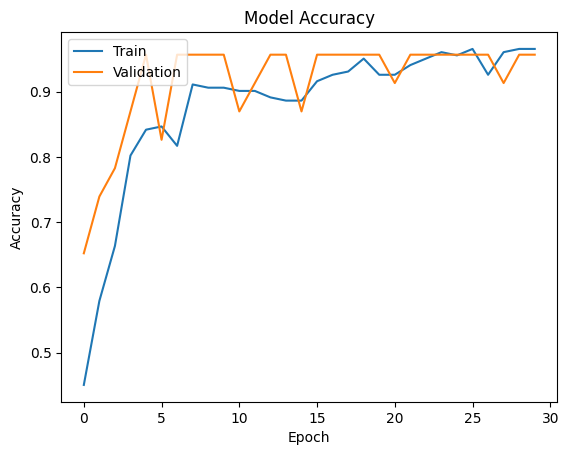

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#The model is showing 96% accuracy for the test data.
accuracy_test = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)
accuracy_train= model.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_val= model.evaluate(X_val_normalized,y_val_encoded, verbose=2)

1/1 - 0s - loss: 0.0995 - accuracy: 0.9615 - 22ms/epoch - 22ms/step
7/7 - 0s - loss: 0.0137 - accuracy: 1.0000 - 42ms/epoch - 6ms/step
1/1 - 0s - loss: 0.1966 - accuracy: 0.9565 - 21ms/epoch - 21ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

1/1 [==============================] - 0s 62ms/step


In [ ]:
y_pred

array([[6.97562937e-05, 1.39691067e-04, 9.99790609e-01],
       [9.99999642e-01, 2.77730891e-07, 1.21431412e-07],
       [9.99981403e-01, 5.32477848e-08, 1.86481375e-05],
       [9.99934912e-01, 1.50441190e-06, 6.35301549e-05],
       [7.52570434e-03, 9.92237985e-01, 2.36384076e-04],
       [9.99998450e-01, 1.48550680e-06, 1.17012071e-07],
       [9.98815536e-01, 3.72318536e-05, 1.14716520e-03],
       [3.94438058e-02, 9.40780640e-01, 1.97756495e-02],
       [1.28721148e-01, 8.37534964e-01, 3.37438807e-02],
       [1.00000000e+00, 1.42716745e-08, 1.67687619e-09],
       [1.03510960e-04, 1.64709496e-03, 9.98249412e-01],
       [9.99999762e-01, 4.50490134e-09, 1.97312943e-07],
       [2.03399416e-02, 9.79650617e-01, 9.48171873e-06],
       [2.88807962e-04, 3.43925378e-04, 9.99367297e-01],
       [6.91618631e-03, 2.86036521e-01, 7.07047284e-01],
       [2.00549202e-05, 1.39555807e-04, 9.99840379e-01],
       [1.00000000e+00, 4.05331185e-11, 3.13998688e-11],
       [1.00000000e+00, 3.35022

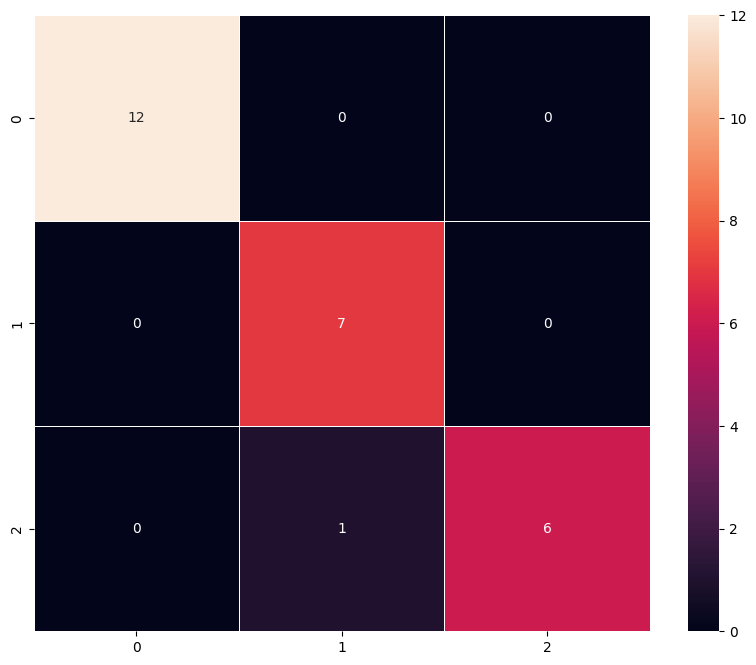

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix()
# The model appears to be a good fit with only one image incorrectly
# classified.
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
#While the original model seems sufficient, we can try
#to improve it.
#The learning rate of the previous code is displayed:
#The Adam optimizer is used and the learning rate is 0.
print(model.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
from keras.callbacks import ReduceLROnPlateau

callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=2)

In [ ]:
history_2 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2,
            callbacks=[callback]
)

Epoch 1/30
7/7 - 0s - loss: 0.1771 - accuracy: 0.9307 - val_loss: 0.8971 - val_accuracy: 0.5217 - lr: 0.0010 - 323ms/epoch - 46ms/step
Epoch 2/30
7/7 - 0s - loss: 0.1942 - accuracy: 0.9208 - val_loss: 0.8368 - val_accuracy: 0.6087 - lr: 0.0010 - 77ms/epoch - 11ms/step
Epoch 3/30
7/7 - 0s - loss: 0.1389 - accuracy: 0.9604 - val_loss: 0.6192 - val_accuracy: 0.8261 - lr: 0.0010 - 83ms/epoch - 12ms/step
Epoch 4/30
7/7 - 0s - loss: 0.1320 - accuracy: 0.9653 - val_loss: 0.8222 - val_accuracy: 0.6522 - lr: 0.0010 - 76ms/epoch - 11ms/step
Epoch 5/30
7/7 - 0s - loss: 0.0965 - accuracy: 0.9653 - val_loss: 0.5664 - val_accuracy: 0.9130 - lr: 0.0010 - 81ms/epoch - 12ms/step
Epoch 6/30
7/7 - 0s - loss: 0.1245 - accuracy: 0.9406 - val_loss: 0.5068 - val_accuracy: 0.9130 - lr: 0.0010 - 80ms/epoch - 11ms/step
Epoch 7/30
7/7 - 0s - loss: 0.1027 - accuracy: 0.9455 - val_loss: 0.7378 - val_accuracy: 0.6522 - lr: 0.0010 - 80ms/epoch - 11ms/step
Epoch 8/30
7/7 - 0s - loss: 0.0828 - accuracy: 0.9752 - val_l

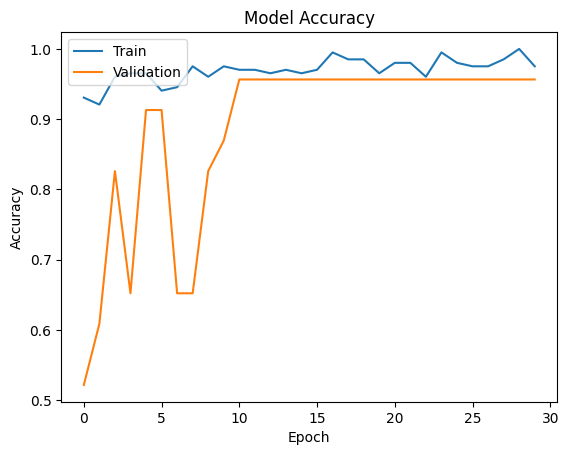

In [ ]:
# We can see the plateu in the validation data accuracy around 12 epochs
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#The model is showing near 100% accuracy for the test data.
accuracy_test = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)
accuracy_train= model.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_val= model.evaluate(X_val_normalized,y_val_encoded, verbose=2)

1/1 - 0s - loss: 0.0876 - accuracy: 1.0000 - 26ms/epoch - 26ms/step
7/7 - 0s - loss: 0.0594 - accuracy: 1.0000 - 44ms/epoch - 6ms/step
1/1 - 0s - loss: 0.1655 - accuracy: 0.9565 - 22ms/epoch - 22ms/step


### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(3, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
3/3 [==============================] - 2s 155ms/step - loss: 1.2818 - accuracy: 0.4855 - val_loss: 1.0526 - val_accuracy: 0.3043
Epoch 2/25
3/3 [==============================] - 0s 103ms/step - loss: 0.6635 - accuracy: 0.7681 - val_loss: 1.0250 - val_accuracy: 0.3043
Epoch 3/25
3/3 [==============================] - 0s 115ms/step - loss: 0.6259 - accuracy: 0.7609 - val_loss: 1.0651 - val_accuracy: 0.3043
Epoch 4/25
3/3 [==============================] - 0s 74ms/step - loss: 0.4942 - accuracy: 0.7899 - val_loss: 1.1132 - val_accuracy: 0.3043
Epoch 5/25
3/3 [==============================] - 0s 105ms/step - loss: 0.4966 - accuracy: 0.7826 - val_loss: 1.1707 - val_accuracy: 0.3043
Epoch 6/25
3/3 [==============================] - 0s 80ms/step - loss: 0.4673 - accuracy: 0.8188 - val_loss: 1.1771 - val_accuracy: 0.3043
Epoch 7/25
3/3 [==============================] - 0s 64ms/step - loss: 0.4446 - accuracy: 0.8478 - val_loss: 1.1420 - val_accuracy: 0.3043
Epoch 8/25
3/3 [=======

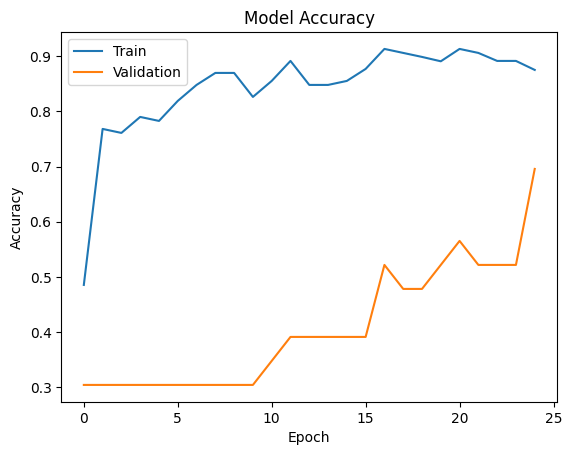

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy_test = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)
accuracy_train= model.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_val= model.evaluate(X_val_normalized,y_val_encoded, verbose=2)

1/1 - 0s - loss: 0.7366 - accuracy: 0.7308 - 21ms/epoch - 21ms/step
7/7 - 0s - loss: 0.7452 - accuracy: 0.6782 - 41ms/epoch - 6ms/step
1/1 - 0s - loss: 0.7706 - accuracy: 0.6957 - 22ms/epoch - 22ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

1/1 [==============================] - 0s 72ms/step


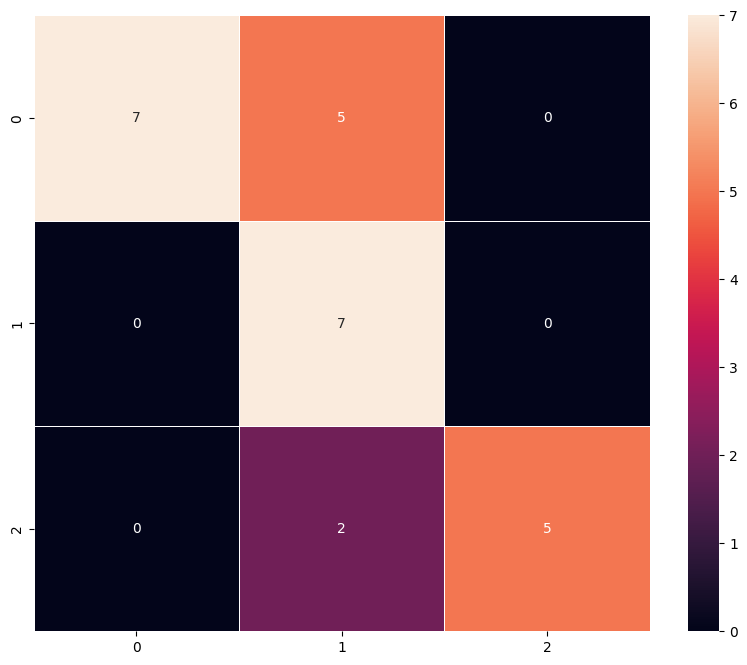

In [ ]:
# This model is showing 7 incorrectly classified images.
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
#Try to use a predefined architecture for transfer learning
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# Making all the layers of the VGG model non-trainable.
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(3, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 14780835 (56.38 MB)
Trainable params: 66

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
3/3 [==============================] - 3s 215ms/step - loss: 1.1938 - accuracy: 0.2971 - val_loss: 0.9707 - val_accuracy: 0.3913
Epoch 2/25
3/3 [==============================] - 0s 144ms/step - loss: 1.0179 - accuracy: 0.4010 - val_loss: 0.8531 - val_accuracy: 0.6522
Epoch 3/25
3/3 [==============================] - 0s 97ms/step - loss: 0.9204 - accuracy: 0.5797 - val_loss: 0.8027 - val_accuracy: 0.6522
Epoch 4/25
3/3 [==============================] - 0s 125ms/step - loss: 0.8312 - accuracy: 0.6522 - val_loss: 0.7273 - val_accuracy: 0.6957
Epoch 5/25
3/3 [==============================] - 0s 131ms/step - loss: 0.7651 - accuracy: 0.7448 - val_loss: 0.6470 - val_accuracy: 0.8261
Epoch 6/25
3/3 [==============================] - 0s 112ms/step - loss: 0.6503 - accuracy: 0.8043 - val_loss: 0.5827 - val_accuracy: 0.9130
Epoch 7/25
3/3 [==============================] - 0s 119ms/step - loss: 0.6545 - accuracy: 0.7500 - val_loss: 0.5255 - val_accuracy: 0.8696
Epoch 8/25
3/3 [=====

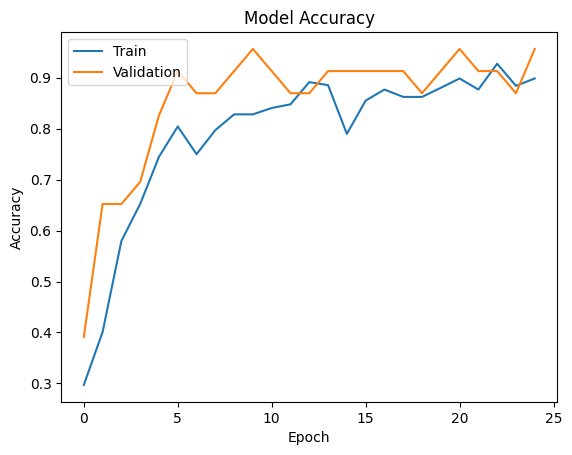

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy_test = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)
accuracy_train= new_model.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_val= new_model.evaluate(X_val_normalized,y_val_encoded, verbose=2)

1/1 - 0s - loss: 0.2119 - accuracy: 0.8846 - 92ms/epoch - 92ms/step
7/7 - 1s - loss: 0.2201 - accuracy: 0.9158 - 1s/epoch - 162ms/step
1/1 - 0s - loss: 0.2129 - accuracy: 0.9565 - 62ms/epoch - 62ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

1/1 [==============================] - 0s 234ms/step


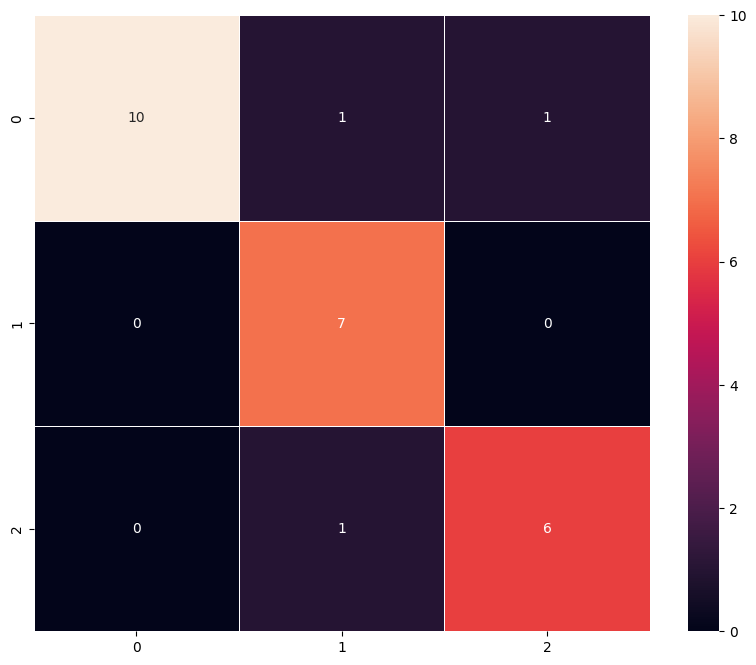

In [ ]:
# This model shows 3 incorrectly classified images.
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [ ]:
#The first sequential model with the Adam optimizer performed the best.
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Reduce LR on Plateau','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['100%','100%','67.8%','91.6%'],'Validation Accuracy':['95.6%','95.6%','69.6%','95.6%'],'Test Accuracy':['96.2%','100%','73.1%','88.5%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,100%,95.6%,96.2%
1,CNN Model with Reduce LR on Plateau,100%,95.6%,100%
2,CNN Model with Data Augmentation,67.8%,69.6%,73.1%
3,Transfer Learning Model,91.6%,95.6%,88.5%


In [ ]:
#Three of the models produced results that are of higher accuracy level.
#The original CNN model using Reduce LR on plateu performed the best.
#Augmentating the data resulted in the least accurate model.

### Visualizing the prediction

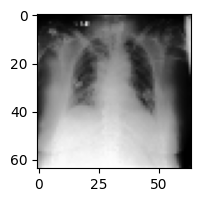

1/1 [==============================] - 0s 38ms/step
Predicted Label ['Covid']
True Label Covid


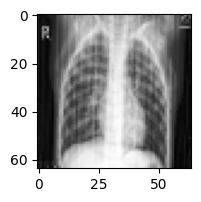

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Viral_Pneumonia']
True Label Viral_Pneumonia


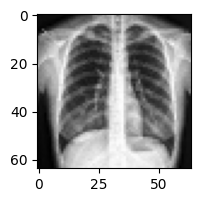

1/1 [==============================] - 0s 33ms/step
Predicted Label ['Normal']
True Label Normal


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[2].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[2])
plt.figure(figsize=(2,2))
plt.imshow(X_test[10])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[10].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[10])

plt.figure(figsize=(2,2))
plt.imshow(X_test[12])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[12].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[12])

## Actionable Insights and Business Recommendations

*The assignment was to be able to classify the incoming images to the three categories of data. This information can be used to create a preliminary analysis tool that can help flag images for x-ray technicians and doctors to review more closely. The results will never be perfect or able to be overlooked completely by a professional, however this can be marketed as a tool for analyizing large quanitites of x-rays or expediting results.

The model may be improved through finding a better transfer learning algorithm than the VGG architecture. The data augmentation results suggest that the current script is susceptible to images with too much variety.

_____